# Package location DoE analysis
*Author: Leo Guo, latest update: December 2023*

The goal of this analysis is to show whether the DoE is sufficiently populated. If so, this yields a credible basis for performing Bayesian optimization.

This analysis consists of two parts: 
1. Sensitivity analysis (index convergence)
2. Regression analysis ($R^2$ convergence)

## 0. Setting up

Make sure to have a Python (3.7+) environment ready. Install (`pip`) and import the following packages:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import f3dasm
import gpytorch
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import SALib
import seaborn as sns

2023-12-10 18:28:16,066 - Imported f3dasm (version: 1.2.0)


Setting a manual RNG seed for reproducibility.

In [2]:
np.random.seed(123)

The next package is not part of the Python Package Index. If the regression analysis is not run, there is no need to import it.

To access the regression analysis, please set `generate_r2` to `True` and visit https://github.com/llguo95/MFB for the installation instructions.

In [3]:
generate_r2 = True
if generate_r2:
    import mfb

Indicate the paths to the data sets:

In [4]:
df_raw = pd.read_csv("doe_data.csv", header=[0, 1], index_col=0)

Let's look at the data set.

In [5]:
df_raw

input                      output
            ddx         ddy rrotz  acc_nlcr
0     49.804310   65.219315    90  0.029127
1    124.647194  143.976028    90  0.032837
2     99.490570   35.937492     0  0.002432
3     41.921356   83.413643     0  0.002963
4     30.330944   34.851994    90  0.042311
..          ...         ...   ...       ...
196   39.896400  105.213371     0  0.002978
197   28.309956   44.020927    90  0.041989
198   84.744522   90.459785    90  0.026269
199  141.377563   57.616295    90  0.018318
200   69.716431  135.457657     0       NaN

[201 rows x 4 columns]

Let's clean up the `NaN` values.

In [6]:
df = df_raw.dropna().reset_index(drop=True)

In [7]:
df

input                      output
            ddx         ddy rrotz  acc_nlcr
0     49.804310   65.219315    90  0.029127
1    124.647194  143.976028    90  0.032837
2     99.490570   35.937492     0  0.002432
3     41.921356   83.413643     0  0.002963
4     30.330944   34.851994    90  0.042311
..          ...         ...   ...       ...
193   97.465607   27.798286     0  0.002418
194   39.896400  105.213371     0  0.002978
195   28.309956   44.020927    90  0.041989
196   84.744522   90.459785    90  0.026269
197  141.377563   57.616295    90  0.018318

[198 rows x 4 columns]

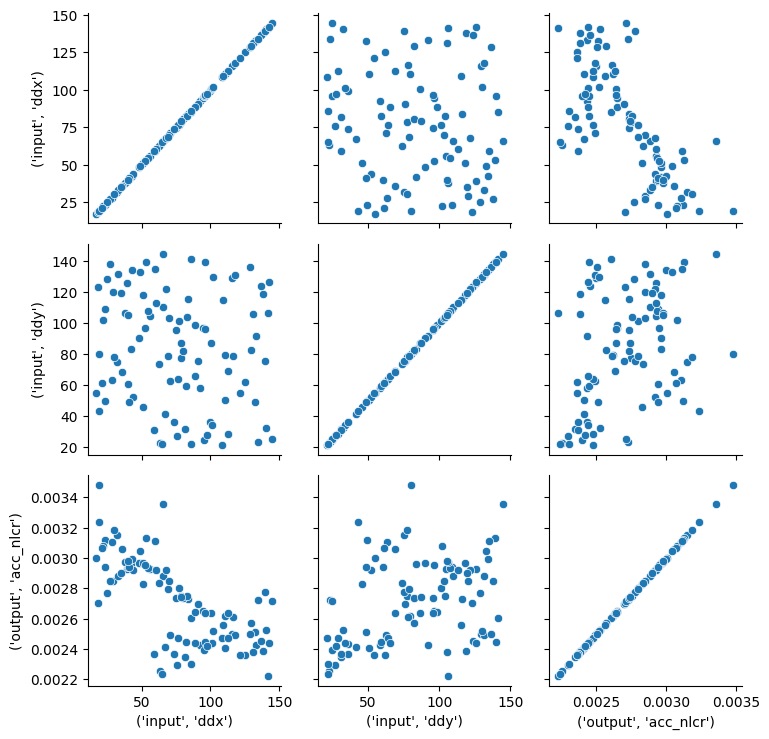

In [8]:
g = sns.PairGrid(df[df.input.rrotz==0].drop(columns=('input', 'rrotz')))
g.map(sns.scatterplot)

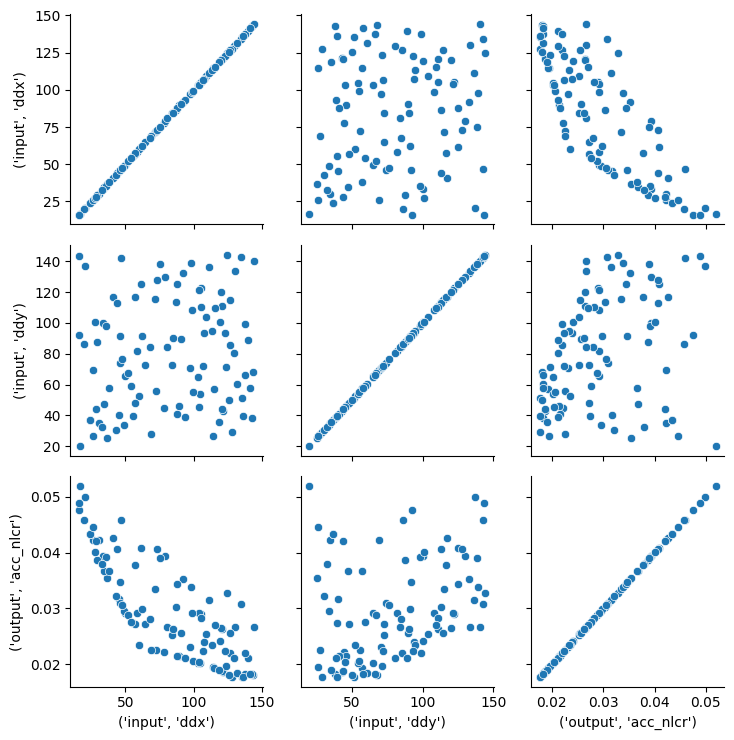

In [9]:
g = sns.PairGrid(df[df.input.rrotz == 90].drop(columns=('input', 'rrotz')))
g.map(sns.scatterplot)

In [10]:
df_rrotz0 = df[df.input.rrotz == 0].drop(columns=('input', 'rrotz')).reset_index(drop=True)

In [11]:
input_hf = df_rrotz0.input.values
output_hf = df_rrotz0.output.values

## 1. Sobol' sensitivity analysis

We use [SALib](https://salib.readthedocs.io/en/latest/) to perform the analysis.

First, let's look at the total (`ST`) and 1st order (`S1`) sensitivity indices when all data points are used.

HF analysis:
Samples:
	2 parameters: ['ddx', 'ddy']
	96 evaluations 

Outputs:
	1 outputs: ['Y']
	96 evaluations 

Analysis:
           ST   ST_conf
ddx  1.216215  0.735275
ddy  1.504752  0.772509 

           S1   S1_conf
ddx -0.370547  0.739750
ddy -0.295466  0.644881 




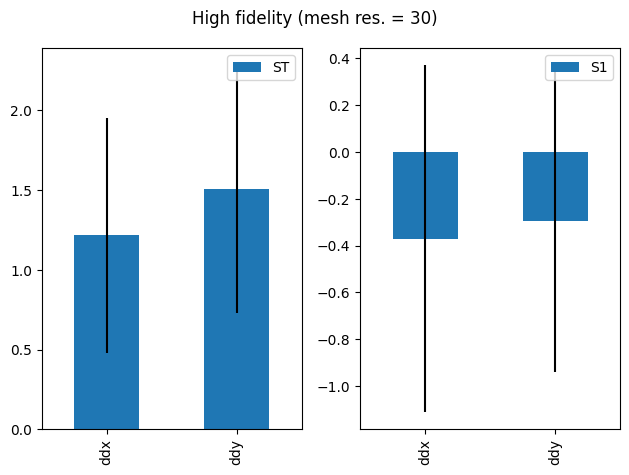

In [12]:
sp = SALib.ProblemSpec({
    'names': ['ddx', 'ddy'],
    'bounds': [
        [15., 145.],
        [20., 145.],
    ],
    'outputs': ['Y']
})

# HF: mesh resolution = ???

X_hf = input_hf
Y_hf = output_hf.flatten()

sp.set_samples(X_hf[:len(X_hf) - len(X_hf) % 4])
sp.set_results(Y_hf[:len(X_hf) - len(X_hf) % 4])

sp.analyze_sobol(calc_second_order=False)
print('HF analysis:')
print(sp)

axes = sp.plot()
plt.suptitle('High fidelity (mesh res. = 30)')
plt.tight_layout()

Let us take a closer look at the sensitivity analyses performed.

By starting off with a small data set and including more and more data points, we get a better idea of how the sensitivity indices behave / converge. By furthermore randomly picking different sets of data for each data quantity, we introduce a statistic for each sensitivity index. 

The next code snippet serves to set this up.

In [13]:
s1_list_trials = []
for trial in range(10):
    s1_list = []
    for i in range(1, (len(X_hf) - len(X_hf) % 4) // 4):
        
        indices = np.random.choice(X_hf.shape[0], size=4 * i)
        index = int(np.random.choice(X_hf.shape[0] - 4 * i, size=1))
        sp.set_samples(X_hf[index:index + 4 * i])
        sp.set_results(Y_hf[index:index + 4 * i])

        sp.analyze_sobol(calc_second_order=False)
        s1_list.append(sp.analysis['S1'])
    s1_list_trials.append(s1_list)

Next, we can plot the `S1` index statistics (median, IQR and whiskers) of each variable. 

The goal is to observe a stabilizing trend for each index.

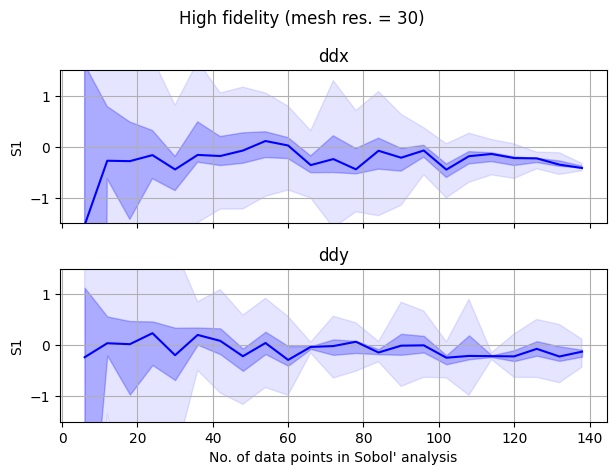

In [14]:
median = np.median(s1_list_trials, axis=0)
q1 = np.quantile(s1_list_trials, axis=0, q=.25)
q3 = np.quantile(s1_list_trials, axis=0, q=.75)
upper_whisker = q3 + 1.5 * (q3 - q1)
lower_whisker = q1 - 1.5 * (q3 - q1)

fig, axs = plt.subplots(2, 1, sharex=True)

for j in range(2):
    axs[j].plot(
        6 * np.arange(1, (len(X_hf) - len(X_hf) % 4) // 4),
        median[:, j],
        color='b', label='median'
    )
    axs[j].fill_between(
        6 * np.arange(1, (len(X_hf) - len(X_hf) % 4) // 4),
        q1[:, j], q3[:, j], alpha=.25,
        color='b', label='IQR'
    )
    axs[j].fill_between(
        6 * np.arange(1, (len(X_hf) - len(X_hf) % 4) // 4),
        lower_whisker[:, j], upper_whisker[:, j], alpha=.1,
        color='b', label='1.5 x IQR'
    )
    # axs[j].set_ylim([median[-1, j] - 1,
    #                 median[-1, j] + 1])        
    axs[j].set_ylim([-1.5, 1.5])
    axs[j].set_title(sp['names'][j])
    axs[j].set_ylabel('S1')
    axs[j].grid()

axs[-1].set_xlabel('No. of data points in Sobol\' analysis')

plt.suptitle('High fidelity (mesh res. = 30)')

plt.tight_layout()

## 2. Gaussian process regression analysis

We use `MFB` to perform the analysis.

First, we split the full input data into train and test data. Since we are only interested in getting accurate fits for the high-fidelity problem, we only apply this splitting to the high-fidelity data.

In [15]:
train_input, test_input = df_rrotz0.input.values[:-10], df_rrotz0.input.values[-10:]
train_output, test_output = df_rrotz0.output.values[:-10], df_rrotz0.output.values[-10:]

Next, we set up the parameters needed to perform Gaussian process regression. We take both single- and multi-fidelity scenarios into account.

In [16]:
#######################
# Parameters: level 1 #
#######################

# Data-related
data_seed = 123
data_output_scaler_lf = StandardScaler()
data_output_scaler_hf = StandardScaler()

bounds = np.array(
        [
            [15., 145.],
            [20., 145.],
        ]
    )

lower, upper = bounds.T

domain = f3dasm.make_nd_continuous_domain(
    bounds=bounds, dimensionality=2
)

# Regression-related
regression_training_iter = 100
regression_opt_kwargs = dict(lr=0.1)
regression_opt_class = torch.optim.Adam
regression_likelihood_class = gpytorch.likelihoods.GaussianLikelihood
regression_mean_base_class = gpytorch.means.ZeroMean
regression_covar_base_class = gpytorch.kernels.RBFKernel

In order to perform analyses based on data structure and number of data points, the following function is defined:

In [17]:
def num_to_surrogate(regression_type, train_size_lf, train_size_hf):

    #######################
    # Parameters: level 2 #
    #######################

    # Regression-related
    regression_parameters_class = getattr(
        mfb.machinelearning.gpr, regression_type + '_Parameters'
    )
    regressor_class = getattr(mfb.machinelearning.gpr, regression_type)

    if regression_type in ["Cokgj", "Cokgd"]:
        if regression_type == "Cokgj":
            regression_noise_fix = 0

        # Note: no fidelity mixture
        regression_mean = torch.nn.ModuleList([
            regression_mean_base_class(),
            regression_mean_base_class(),
        ])
        # Note: no fidelity mixture
        regression_covar = torch.nn.ModuleList([
            gpytorch.kernels.ScaleKernel(regression_covar_base_class()),
            gpytorch.kernels.ScaleKernel(regression_covar_base_class()),
        ])
    else:
        regression_noise_fix = False
        regression_mean = regression_mean_base_class()
        regression_covar = gpytorch.kernels.ScaleKernel(
            regression_covar_base_class()
        )

    #######################
    # Parameters: level 3 #
    #######################

    # Regression-related
    regression_parameters = regression_parameters_class(
        likelihood=regression_likelihood_class(),
        kernel=regression_covar,
        mean=regression_mean,
        noise_fix=regression_noise_fix,
        opt_algo=regression_opt_class,
        opt_algo_kwargs=regression_opt_kwargs,
        training_iter=regression_training_iter,
    )

    train_data = []

    for i, n in enumerate([train_size_lf, train_size_hf]):
        samples_fidelity = f3dasm.ExperimentData(design=domain)

        if i == 0:
            input_arr = train_input
            output_arr = train_output
        else:
            input_arr = train_input
            output_arr = train_output

        # Scale the input data
        input_arr_scaled = (input_arr - lower) / (upper - lower)

        # Scale the output data
        if i == 0:
            output_arr_scaled = data_output_scaler_lf.fit_transform(output_arr)
        else:
            output_arr_scaled = data_output_scaler_hf.fit_transform(output_arr)

        # Select random samples
        indices = np.random.choice(input_arr_scaled.shape[0], size=n)
        samples_fidelity.add_numpy_arrays(input_arr_scaled[indices], output_arr_scaled[indices])

        train_data.append(samples_fidelity)

    if regression_type == 'Sogpr':
        regression_train_data = train_data[1]
    else:
        regression_train_data = train_data
        
    #####################
    # Regression result #
    #####################

    regressor = regressor_class(
        train_data=regression_train_data,
        parameter=regression_parameters,
    )

    surrogate = regressor.train()

    return surrogate

In [18]:
train_size_hf_range = 5 * np.arange(1, 11)

In [19]:
if False:
    r2_scores_dict = {}
    for regression_type in ['Sogpr']:
        test_input_hf_scaled = torch.tensor((test_input - lower) / (upper - lower)).to(torch.float32)

        r2_scores = []
        for train_size_hf in train_size_hf_range:
            r2_scores_size = []
            for trial in range(10):
                print(regression_type, train_size_hf, trial)
                surrogate = num_to_surrogate(regression_type=regression_type, train_size_lf=350, train_size_hf=train_size_hf)
                test_output_hf_pred = data_output_scaler_hf.inverse_transform(
                    surrogate.predict(
                            test_x=test_input_hf_scaled
                        ).mean[:, None]
                    )
                r2_scores_size.append(r2_score(y_true=test_output, y_pred=test_output_hf_pred))
            r2_scores.append(r2_scores_size)
        r2_scores_dict[regression_type] = np.array(r2_scores)

        df = pd.DataFrame(index=train_size_hf_range, data=r2_scores_dict[regression_type]).rename_axis('train_size_hf', axis=1)
        df.to_csv('r2_%s.csv' % regression_type)

In [20]:
df_r2_sf = pd.read_csv("r2_Sogpr.csv")

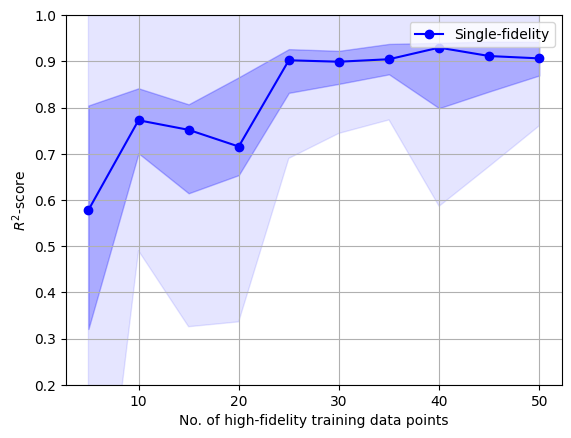

In [21]:
for label, color, df in zip(['Single-fidelity'], ['b'], [df_r2_sf]):
    median = np.median(np.array(df), axis=1)
    q1 = np.quantile(np.array(df), axis=1, q=.25)
    q3 = np.quantile(np.array(df), axis=1, q=.75)
    upper_whisker = np.clip(q3 + 1.5 * (q3 - q1), a_min=None, a_max=1)
    lower_whisker = q1 - 1.5 * (q3 - q1)

    plt.plot(train_size_hf_range, median, '-o', label=label, color=color)
    plt.fill_between(train_size_hf_range, q1, q3, alpha=.25, color=color)
    plt.fill_between(train_size_hf_range, lower_whisker,
                     upper_whisker, alpha=.1, color=color)

plt.xlabel("No. of high-fidelity training data points")
plt.ylabel("$R^2$-score")
plt.ylim([.2, 1.])
plt.grid()
plt.legend()
plt.show()